<a href="https://www.kaggle.com/code/amirkouchaki/fraud-detection?scriptVersionId=300018308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Credit Card Fraud Detection


## A. Setup & Reproducibility

In [1]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings("ignore")

# ===== Global config =====
DEBUG = False
N_SPLITS = 5
RANDOM_SEED = 42
TARGET = "Class"
ID_COL = None

# Modeling controls
PRIMARY_METRIC = "pr_auc"  # for severe imbalance
USE_TIME_SPLIT = False
TIME_COL = "Time"
USE_GPU = False  # keep CPU first; switch to True only if needed and supported
DEBUG_SAMPLE_FRAC = 0.10
DROP_DUPLICATES = True

# Keep idea from original notebook
USE_NOTEBOOK_FEATURE_DROP = True
NOTEBOOK_DROP_COLS = ["V22", "V23", "V24", "V25", "V26", "V27", "V28"]

# Optional manual path overrides
TRAIN_PATH = None
TEST_PATH = None
SAMPLE_SUB_PATH = None

def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(RANDOM_SEED)
print(f"Seed fixed at {RANDOM_SEED}")

Seed fixed at 42


## Kaggle Runtime Instructions
1. Add your dataset from the right sidebar using **Add data**.
2. Read files from `/kaggle/input/...`.
3. Save outputs to `/kaggle/working/...`.
4. Run all cells top-to-bottom.
5. CPU is the default and recommended start. Enable GPU only if training time is a bottleneck and GPU support is stable for the chosen library.


## B. Load Data (Kaggle paths)


In [2]:
def auto_detect_paths():
    csv_files = sorted(glob.glob("/kaggle/input/**/*.csv", recursive=True))

    train_path = None
    test_path = None
    sample_path = None

    for p in csv_files:
        base = os.path.basename(p).lower()
        if "sample" in base and "submission" in base:
            sample_path = p

    for p in csv_files:
        base = os.path.basename(p).lower()
        if train_path is None and base == "train.csv":
            train_path = p
        if test_path is None and base == "test.csv":
            test_path = p

    if train_path is None:
        credit = [p for p in csv_files if "creditcard" in os.path.basename(p).lower()]
        if credit:
            train_path = credit[0]

    if train_path is None and csv_files:
        train_path = csv_files[0]

    return train_path, test_path, sample_path, csv_files

def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH, sample_sub_path=SAMPLE_SUB_PATH):
    auto_train, auto_test, auto_sample, csv_files = auto_detect_paths()

    train_path = train_path or auto_train
    test_path = test_path or auto_test
    sample_sub_path = sample_sub_path or auto_sample

    if train_path is None:
        raise ValueError("No CSV file found in /kaggle/input")

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path) if test_path and os.path.exists(test_path) else None
    sample_sub = pd.read_csv(sample_sub_path) if sample_sub_path and os.path.exists(sample_sub_path) else None

    if DEBUG and TARGET in train_df.columns:
        train_df = (
            train_df.groupby(TARGET, group_keys=False)
            .apply(lambda x: x.sample(frac=DEBUG_SAMPLE_FRAC, random_state=RANDOM_SEED))
            .reset_index(drop=True)
        )

    print("Detected CSV files:")
    for p in csv_files:
        print(" -", p)

    print("\nUsing train:", train_path)
    print("Using test :", test_path)
    print("Using sample submission:", sample_sub_path)
    print("Train shape:", train_df.shape)
    if test_df is not None:
        print("Test shape :", test_df.shape)
    if sample_sub is not None:
        print("Sample shape:", sample_sub.shape)

    return train_df, test_df, sample_sub, train_path, test_path, sample_sub_path

train_df, test_df, sample_sub, TRAIN_PATH, TEST_PATH, SAMPLE_SUB_PATH = load_data()
display(train_df.head(3))


Detected CSV files:
 - /kaggle/input/fraud-detection/creditcard.csv

Using train: /kaggle/input/fraud-detection/creditcard.csv
Using test : None
Using sample submission: None
Train shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


## C. Quick EDA (model-relevant checks only)


Shape: (284807, 31)

Missing values (top 10):
Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
dtype: int64

Target distribution (Class):
Class
0    284315
1       492
Name: count, dtype: int64

Target ratio:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Duplicate rows: 1081

Dtypes:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


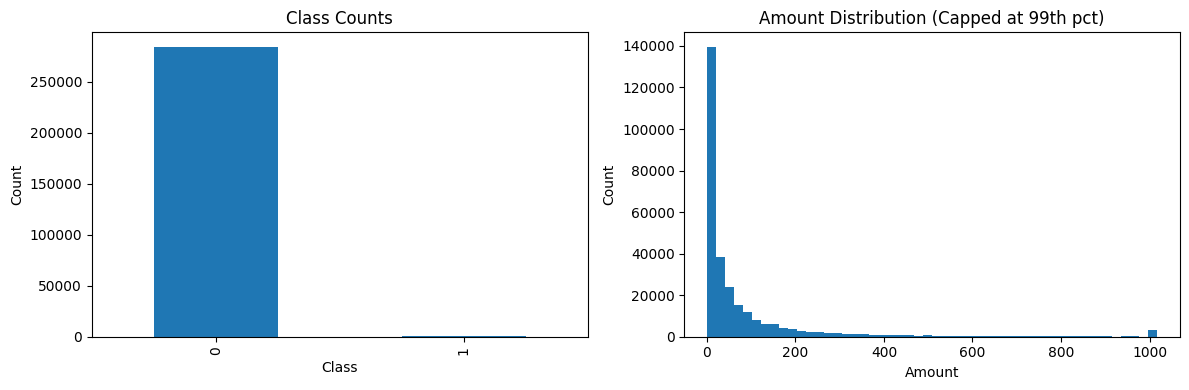

In [3]:
def quick_eda(df, target=TARGET):
    print("Shape:", df.shape)
    print("\nMissing values (top 10):")
    print(df.isna().sum().sort_values(ascending=False).head(10))

    if target in df.columns:
        print(f"\nTarget distribution ({target}):")
        print(df[target].value_counts(dropna=False))
        print("\nTarget ratio:")
        print(df[target].value_counts(normalize=True))

    print("\nDuplicate rows:", int(df.duplicated().sum()))
    print("\nDtypes:")
    print(df.dtypes)

quick_eda(train_df)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train_df[TARGET].value_counts().plot(kind="bar", ax=ax[0], title="Class Counts")
ax[0].set_xlabel(TARGET)
ax[0].set_ylabel("Count")

if "Amount" in train_df.columns:
    clipped = train_df["Amount"].clip(upper=train_df["Amount"].quantile(0.99))
    ax[1].hist(clipped, bins=50)
    ax[1].set_title("Amount Distribution (Capped at 99th pct)")
    ax[1].set_xlabel("Amount")
    ax[1].set_ylabel("Count")
else:
    ax[1].axis("off")

plt.tight_layout()
plt.show()


## D. Problem Framing (binary classification + imbalance)

- Target is binary (`Class`).
- Positive class is rare, so accuracy alone is not sufficient.
- We prioritize ROC-AUC, PR-AUC, and F1.


## E. Split Strategy

- Default: `StratifiedKFold` to preserve class ratio in each fold.
- If strict temporal validation is required by the task, use a time-based split strategy instead.


## F. Preprocessing, G. Baseline Model, H. Strong Model, I. Thresholding


In [4]:
def leakage_guard(train_df, test_df=None, target=TARGET, id_col=ID_COL):
    if target not in train_df.columns:
        raise ValueError(f"Target column '{target}' is missing in train data.")

    if test_df is not None and target in test_df.columns:
        raise ValueError("Leakage risk: target column appears in test data.")

    if id_col is not None and test_df is not None:
        if id_col in train_df.columns and id_col in test_df.columns:
            overlap = np.intersect1d(train_df[id_col].values, test_df[id_col].values).size
            print(f"ID overlap count ({id_col}): {overlap}")
            if overlap > 0:
                raise ValueError("Leakage risk: overlapping IDs between train and test.")

def make_splits(X, y, n_splits=N_SPLITS, random_seed=RANDOM_SEED, use_time_split=USE_TIME_SPLIT, time_col=TIME_COL):
    if use_time_split and time_col in X.columns:
        print("Time column exists. This notebook still uses StratifiedKFold by default.")
        print("Switch to custom time split if your evaluation protocol requires temporal separation.")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    return list(skf.split(X, y))

def build_preprocessor(X):
    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ])

    return preprocessor, numeric_cols, categorical_cols

def evaluate(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "pr_auc": average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

def train_model(X, y, splits, preprocessor, model_type="baseline"):
    fold_scores = []
    oof_pred = np.zeros(len(X), dtype=float)
    models = []

    for fold, (tr_idx, va_idx) in enumerate(splits, 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        if model_type == "baseline":
            # Full leakage-safe pipeline (preprocess fit only on fold train)
            pipe = Pipeline([
                ("prep", clone(preprocessor)),
                ("clf", LogisticRegression(
                    max_iter=2000 if not DEBUG else 500,
                    class_weight="balanced",
                    solver="liblinear",
                    random_state=RANDOM_SEED
                ))
            ])
            pipe.fit(X_tr, y_tr)
            va_prob = pipe.predict_proba(X_va)[:, 1]
            models.append(pipe)

        elif model_type == "strong":
            from catboost import CatBoostClassifier

            prep = clone(preprocessor)
            X_tr_p = prep.fit_transform(X_tr)
            X_va_p = prep.transform(X_va)

            if hasattr(X_tr_p, "toarray"):
                X_tr_p = X_tr_p.toarray()
                X_va_p = X_va_p.toarray()

            params = dict(
                iterations=3000 if not DEBUG else 400,
                learning_rate=0.03 if not DEBUG else 0.08,
                depth=6 if not DEBUG else 5,
                l2_leaf_reg=6,
                loss_function="Logloss",
                eval_metric="AUC",
                auto_class_weights="Balanced",
                random_seed=RANDOM_SEED,
                verbose=False
            )
            if USE_GPU:
                params["task_type"] = "GPU"

            model = CatBoostClassifier(**params)
            model.fit(
                X_tr_p, y_tr,
                eval_set=(X_va_p, y_va),
                use_best_model=True,
                early_stopping_rounds=200 if not DEBUG else 50
            )

            va_prob = model.predict_proba(X_va_p)[:, 1]
            models.append((prep, model))

        else:
            raise ValueError("model_type must be 'baseline' or 'strong'")

        oof_pred[va_idx] = va_prob
        score = evaluate(y_va, va_prob, threshold=0.5)
        fold_scores.append(score)

        print(
            f"{model_type:8s} | Fold {fold}/{len(splits)} | "
            f"ROC-AUC={score['roc_auc']:.5f} | PR-AUC={score['pr_auc']:.5f} | F1@0.5={score['f1']:.5f}"
        )

    score_df = pd.DataFrame(fold_scores)
    print(f"\n{model_type.upper()} CV summary (mean/std)")
    display(score_df.agg(["mean", "std"]).T)

    return {
        "model_type": model_type,
        "models": models,
        "oof_pred": oof_pred,
        "fold_scores": score_df
    }

def predict_test(model_bundle, X_test):
    if X_test is None:
        return None

    preds = []
    if model_bundle["model_type"] == "baseline":
        for pipe in model_bundle["models"]:
            preds.append(pipe.predict_proba(X_test)[:, 1])
    else:
        for prep, model in model_bundle["models"]:
            Xt = prep.transform(X_test)
            if hasattr(Xt, "toarray"):
                Xt = Xt.toarray()
            preds.append(model.predict_proba(Xt)[:, 1])

    return np.mean(preds, axis=0)

def best_threshold_by_f1(y_true, y_prob):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_f1 = 0.5, -1.0
    for t in thresholds:
        s = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
        if s > best_f1:
            best_f1 = s
            best_t = t
    return best_t, best_f1


## J. Final Training + Cross-Validated Evaluation


In [5]:
# Safety checks
leakage_guard(train_df, test_df, TARGET, ID_COL)

# Optional cleanup
if DROP_DUPLICATES:
    before = len(train_df)
    train_df = train_df.drop_duplicates().reset_index(drop=True)
    print(f"Dropped duplicate rows: {before - len(train_df)}")

# Feature selection (keeps original notebook idea)
drop_cols = [c for c in NOTEBOOK_DROP_COLS if USE_NOTEBOOK_FEATURE_DROP and c in train_df.columns]
if drop_cols:
    print("Dropped feature columns:", drop_cols)

feature_cols = [c for c in train_df.columns if c != TARGET and c not in drop_cols]
X = train_df[feature_cols].copy()
y = train_df[TARGET].astype(int).copy()

# Prepare test features if test exists
X_test = None
if test_df is not None:
    for c in feature_cols:
        if c not in test_df.columns:
            test_df[c] = np.nan
    X_test = test_df[feature_cols].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

preprocessor, num_cols, cat_cols = build_preprocessor(X)
print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

splits = make_splits(X, y)

# Baseline
baseline_bundle = train_model(X, y, splits, preprocessor, model_type="baseline")

# Strong model
strong_bundle = train_model(X, y, splits, preprocessor, model_type="strong")

# OOF comparison
baseline_oof_metrics = evaluate(y, baseline_bundle["oof_pred"], threshold=0.5)
strong_oof_metrics = evaluate(y, strong_bundle["oof_pred"], threshold=0.5)

comparison = pd.DataFrame([baseline_oof_metrics, strong_oof_metrics], index=["baseline", "strong"])
print("\nOOF metric comparison:")
display(comparison)

if strong_oof_metrics[PRIMARY_METRIC] >= baseline_oof_metrics[PRIMARY_METRIC]:
    best_name = "strong"
    best_bundle = strong_bundle
    best_oof = strong_bundle["oof_pred"]
else:
    best_name = "baseline"
    best_bundle = baseline_bundle
    best_oof = baseline_bundle["oof_pred"]

thr, thr_f1 = best_threshold_by_f1(y, best_oof)
print(f"Selected model: {best_name}")
print(f"Best threshold by OOF F1: {thr:.2f} (F1={thr_f1:.5f})")


Dropped duplicate rows: 1081
Dropped feature columns: ['V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
X shape: (283726, 23)
y shape: (283726,)
Numeric columns: 23
Categorical columns: 0
baseline | Fold 1/5 | ROC-AUC=0.98663 | PR-AUC=0.75914 | F1@0.5=0.11525
baseline | Fold 2/5 | ROC-AUC=0.98454 | PR-AUC=0.72590 | F1@0.5=0.11932
baseline | Fold 3/5 | ROC-AUC=0.98174 | PR-AUC=0.69236 | F1@0.5=0.12202
baseline | Fold 4/5 | ROC-AUC=0.96751 | PR-AUC=0.70650 | F1@0.5=0.11338
baseline | Fold 5/5 | ROC-AUC=0.97755 | PR-AUC=0.71058 | F1@0.5=0.11168

BASELINE CV summary (mean/std)


,mean,std
roc_auc,0.979593,0.007560
pr_auc,0.718896,0.025472
f1,0.116330,0.004267


strong   | Fold 3/5 | ROC-AUC=0.98050 | PR-AUC=0.68986 | F1@0.5=0.31538
strong   | Fold 4/5 | ROC-AUC=0.97749 | PR-AUC=0.62720 | F1@0.5=0.23478
strong   | Fold 5/5 | ROC-AUC=0.98521 | PR-AUC=0.80305 | F1@0.5=0.66939

STRONG CV summary (mean/std)


,mean,std
roc_auc,0.982685,0.007701
pr_auc,0.738410,0.079541
f1,0.478925,0.254049



OOF metric comparison:


,roc_auc,pr_auc,f1
baseline,0.979197,0.716541,0.116185
strong,0.964307,0.751333,0.385520


Selected model: strong
Best threshold by OOF F1: 0.91 (F1=0.79783)
